In [2]:
import sys
!{sys.executable} -m pip install pyfinance
!{sys.executable} -m pip install datar
!{sys.executable} -m pip install pandas --upgrade
!{sys.executable} -m pip install plotnine
!{sys.executable} -m pip install numexpr

     |████████████████████████████████| 57 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 106.7 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 88.0 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 17.2 MB/s  eta 0:00:01
     |████████████████████████████████| 109 kB 134.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 19.7 MB/s  eta 0:00:01
     |████████████████████████████████| 9.9 MB 98.9 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 87.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 16.5 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 18.3 MB/s  eta 0:00:01
     |████████████████████████████████| 11.5 MB 37.0 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.2
    Uninstalling pandas-1.2.2:
      Successfully uninstalled pandas-1.2.2
     |████████████████████████████████| 4.7 MB 52.5 MB/s eta 0:00:01
     |██████████

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select

[2021-12-31 11:32:45][datar][WARNING] Builtin name "filter" has been overriden by datar.


In [2]:
full_data = pd.read_excel('isx2010C.xls', sheet_name = 'isx19112010C')
print(full_data.shape)

(90, 49)


In [3]:
def transform_data(data):
    # Rename the columns
    column_len = len(data.columns.values)
    renamed_data = data[:]
    renamed_data.rename({
        data.columns.values[0]: "T",
        data.columns.values[column_len - 1]: 'date', 
        data.columns.values[column_len - 2]: 'r', 
        data.columns.values[column_len - 3]: 'S'
    }, inplace=True, axis="columns")
    # Transform into row form and drop NA rows:
    renamed_data = renamed_data.melt(id_vars=['T', 'date', 'r', 'S'], var_name="E")
    renamed_data = renamed_data.dropna()
    renamed_data.rename({'value':'Cobs'}, axis='columns', inplace=True)
    renamed_data['Cobs'] = renamed_data['Cobs'].replace(',','.', regex=True).astype(float)
    renamed_data['E'] = renamed_data['E'].astype(float)
    # Scale the time to maturity and risk-free rate. Convert to float
    scaled_data = renamed_data >> mutate(r = f.r/100, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)

    # Calculate volatility and drop NA
    volatile_data = scaled_data.apply(lambda row:  BSM(kind='call', S0=row['S'], K=row['E'], T= row['T'], r=row['r'], sigma=1.0).implied_vol(value = row['Cobs']), axis = 1)
    scaled_data['volatility'] = volatile_data
    scaled_data = scaled_data.dropna()

    # Computing the Delta and vega values for each option at each point in time using the implied volatilities
    deltas = scaled_data.apply(lambda row:  BSM(kind='call', S0=row['S'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).delta(), axis=1)
    vegas = scaled_data.apply(lambda row:  BSM(kind='call', S0=row['S'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).vega(), axis=1)
    scaled_data['delta'] = deltas
    scaled_data['vega'] = vegas
    scaled_data["timestamp"] = scaled_data.apply(lambda row: pd.to_datetime(row["date"], format="%d.%m.%Y").timestamp(), axis=1)
    
    # Sort by the time to maturity
    scaled_data = scaled_data.sort_values(by=["T"], ascending=False)

    # Again, dropping any NA rows
    scaled_data = scaled_data.dropna()
    return scaled_data


In [4]:
parsed_data = transform_data(full_data)

/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


In [5]:
# Delta hedging code:
def delta_hedge(total_data, day_index = 40, strike_price = 515/1000, day_delta = 2):
    # Default arguments:
    maturity = day_index/252
    
    # Get the data of the specified option for days until maturity:
    parsed_data = total_data[(total_data['T'] <= maturity) & (total_data['E'] == strike_price)]
    
    # If no data found for the specified strike or maturity, return NaN:
    if parsed_data.empty is True:
        return [np.nan, np.nan]
    
    # Setup the appropriate variables:
    errors, option_portfolios, replicating_portfolios, deltas = [], [], [], []
    
    # Form the first replicating and underlying option portfolios:
    current_option = parsed_data.iloc[0]
    current_delta = current_option['delta']
    current_price = current_option['S']
    current_replicating_port = current_delta * current_price
    current_option_port = current_option['Cobs']
    
    # First day t = 0:
    replicating_portfolios.append(current_replicating_port)
    option_portfolios.append(current_option_port)
    
    # The days until hedging:
    time_to_hedge = day_delta - 1
    
    i = 1
    # Each day until maturity
    for index, row in parsed_data.iloc[1:].iterrows():
        
        # Get the new option instance:
        current_option = row
        current_price = row['S']
        
        # Calculate the new replicating portfolio value:
        current_replicating_port = current_price * current_delta
        replicating_portfolios.append(current_replicating_port)

        # Calculate change of replicating portfolio
        replicating_value_change = (replicating_portfolios[i] - replicating_portfolios[i - 1])

        # Calculate new option portfolio value:
        current_option_port = current_option['Cobs']
        option_portfolios.append(current_option_port)
        option_value_change = (option_portfolios[i] - option_portfolios[i - 1])
        a = (option_value_change - replicating_value_change)
        errors.append(a)
        
        # Hedging:
        if time_to_hedge == 0:
            time_to_hedge = day_delta
            # Rehedge by setting the delta to a new value
            current_delta = current_option['delta']
            
            # Modify the previous replicating portfolio by taking the new delta into account:
            replicating_portfolios[i] = current_price * current_delta
        
        deltas.append(current_delta)
        time_to_hedge = time_to_hedge - 1
        i = i + 1
        
    # Return mean and std of A^2
    return (np.mean(np.square(errors)), np.nanstd(np.square(errors)))

In [6]:
delta_hedge(parsed_data, 45, day_delta=14)

(1.6269048179510107e-06, 2.7079718506065547e-06)

## Multiple sheets

In [7]:
# Get all of the sheets in different dataframes
dataframes = []
for i in range(12):
    d = pd.read_excel('isx2010C.xls', sheet_name = i)
    dataframes.append(transform_data(d))

In [8]:
# finding common strike prices for all sheets
common_strikes = set(dataframes[0]['E'].unique())
for i in range(11):
    s = set(dataframes[i + 1]['E'].unique())
    common_strikes = common_strikes & s

In [9]:
# Try strike prices with 10 increments starting from 340, scaled by 1000
possible_strikes = np.array([340 + i * 10 for i in range(21)]) / 1000
print(np.all([possible_strikes[i] in common_strikes for i in range(possible_strikes.shape[0])]))

True


In [10]:
strike_prices = possible_strikes
freqs = [2, 4, 7, 10, 14, 18]
starting_ttm = np.arange(20, 46, 2)

In [11]:
# Now we hedge multiple different strikes and combine the results
result_rows = []
for start_index, start_ttm in enumerate(starting_ttm):
    for data_index, dataframe in enumerate(dataframes):
        parsed_dataframe = dataframe[dataframe["T"] <= start_ttm / 252]
        current_row = parsed_dataframe.iloc[0]
        current_price = current_row['S']
        atm_index = np.abs(np.array(strike_prices) - current_price).argmin()
        for i, s in enumerate(strike_prices):
            for time_index, t in enumerate(freqs):
                # If the strike price is closest to the starting price, we consider is hedging with an ATM option, otherwise the option is considerer either ITM or OTM.
                if i == atm_index:
                    call_type = "ATM"
                elif i < atm_index:
                    call_type = "ITM"
                else:
                    call_type = "OTM"
                hedge_result = delta_hedge(dataframe, start_ttm, strike_price = s, day_delta = t)
                data_row = [s, t, start_ttm, data_index, call_type, hedge_result[0], hedge_result[1]]
                result_rows.append(data_row)

/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [12]:
# Create a dataframe with the results:
delta_hedge_results = pd.DataFrame(result_rows, columns = ["E", "Frequency", "TTM", "Sheet", "Type", "Mean", "Std"])

In [13]:
delta_hedge_results

,E,Frequency,TTM,Sheet,Type,Mean,Std
,<float64>,<int64>,<int64>,<int64>,<object>,<float64>,<float64>
0,0.34,2,20,0,ITM,1.823247e-07,3.122009e-07
1,0.34,4,20,0,ITM,1.874259e-07,3.148240e-07
2,0.34,7,20,0,ITM,1.797122e-07,3.028155e-07
3,0.34,10,20,0,ITM,1.925762e-07,3.259995e-07
...,...,...,...,...,...,...,...
4,0.34,14,20,0,ITM,1.909773e-07,3.260175e-07
19651,0.54,4,44,11,OTM,1.084023e-06,1.667127e-06
19652,0.54,7,44,11,OTM,9.479661e-07,1.577130e-06
19653,0.54,10,44,11,OTM,9.521037e-07,1.465555e-06


## Delta-Vega hedging

In [14]:
# Load 2 different maturity datasets
original_data = pd.read_excel("isx2010C.xls", sheet_name = 0)
original_data = transform_data(original_data)
replicate_data = pd.read_excel("isx2010C.xls", sheet_name = 1)
replicate_data = transform_data(replicate_data)

/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


In [15]:
# Function for DV -hedging.
# Arguments: the dataframes of two different maturities and the common strike price.
def delta_vega_hedging(original_data, replicating_data, ttm, strike_price = 515/1000, day_delta = 2):
    # Calculate the first and last dates of the original dataset and ttm.
    last_date_original = original_data.iloc[original_data.shape[0] - 1]
    first_date_original = original_data[original_data["T"] <= ttm].iloc[0]
    
    # Restrict the replicating portfolio data to this range:
    replicating_parsed = replicating_data[(replicating_data["E"] == strike_price) & (replicating_data['timestamp'] >= first_date_original['timestamp']) & (replicating_data['timestamp'] <= last_date_original['timestamp'])]
    original_parsed = original_data[(original_data["T"] <= ttm) & (original_data["E"] == strike_price)]
    
    # The original call portfolio, replicating call portfolio and underlying stock portfolio:
    option_portfolios, replicating_portfolios, underlying_portfolios = [], [], []
    
    error_return = [np.nan, np.nan]
    if replicating_parsed.shape[0] < original_parsed.shape[0]:
        return error_return
    if original_parsed.empty:
        return error_return
    
    # The current option instances
    current_original = original_parsed.iloc[0]
    current_replicating = replicating_parsed.iloc[0]
    current_price = current_original["S"]
    
    # If not same pricepoint, error!
    if current_price != current_replicating["S"]:
        return error_return
    assert current_price == current_replicating["S"]
    
    # Calculate the first greeks
    current_option_delta = current_original["delta"]
    current_replicating_delta = current_replicating["delta"]
    current_option_vega = current_original["vega"]
    current_replicating_vega = current_replicating["vega"]
    
    # Store all computed greeks:
    option_deltas, replicating_deltas = [current_option_delta], [current_replicating_delta]
    option_vegas, replicating_vegas = [current_option_vega], [current_replicating_vega]
    
    # Compute ratios alpha and eta:
    current_eta = current_option_vega / current_replicating_vega
    current_alpha = current_option_delta - current_eta * current_replicating_delta
    
    # Compute the first portfolios:
    current_option_value = current_original["Cobs"]
    current_underlying_value = current_alpha * current_price
    current_replicating_value = current_eta * current_replicating["Cobs"]
    
    # Store portfolios:
    option_values = [current_option_value]
    underlying_values = [current_underlying_value]
    replicating_values = [current_replicating_value]
    errors = []
    time_to_hedge = day_delta - 1
    i = 1
    
    # Continue until end of original option data:
    for index, row in original_parsed[1:].iterrows():
        # Get the current instance
        current_original = row
        current_price = current_original["S"]
        # Get the same from other sheet:
        current_replicating = replicating_parsed.iloc[i]
        
        # Calculate the new values and store new portfolios:
        current_option_value = current_original["Cobs"]
        option_values.append(current_option_value)
        current_underlying_value = current_alpha * current_price
        underlying_values.append(current_underlying_value)
        current_replicating_value = current_eta * current_replicating["Cobs"]
        replicating_values.append(current_replicating_value)
        
        # Calculate change:
        option_change = option_values[i] - option_values[i - 1]
        underlying_change = underlying_values[i] - underlying_values[i - 1]
        replicating_change = replicating_values[i] - replicating_values[i - 1]
        
        # Total change:
        a = option_change - (underlying_change + replicating_change)
        
        # Hedging:
        if time_to_hedge == 0:
            time_to_hedge = day_delta
            
            # Calculate the greeks delta and vega:
            current_option_delta = current_original["delta"]
            current_replicating_delta = current_replicating["delta"]
            current_option_vega = current_original["vega"]
            current_replicating_vega = current_replicating["vega"]
            
            # Compute ratios alpha and eta:
            current_eta = current_option_vega / current_replicating_vega
            current_alpha = current_option_delta - current_eta * current_replicating_delta
            
            # Compute the portfolios:
            current_underlying_value = current_alpha * current_price
            current_replicating_value = current_eta * current_replicating["Cobs"]

            # Modify the previous portfolios by taking the new delta into account:
            underlying_values[i] = current_underlying_value
            replicating_values[i] = current_replicating_value
        
        # Store the greeks used:
        option_deltas.append(current_option_delta)
        replicating_deltas.append(current_replicating_delta)
        option_vegas.append(current_option_vega)
        replicating_vegas.append(current_replicating_vega)
        
        time_to_hedge = time_to_hedge - 1
        i = i + 1
        errors.append(a)
    return (np.nanmean(np.square(errors)), np.nanstd(np.square(errors)))

In [16]:
good_strike = 540/1000
day_d = 4
ttm = 40

In [17]:
delta_vega_hedging(original_data, replicate_data, ttm=ttm/252, strike_price = good_strike, day_delta = day_d)

(6.657262152396561e-07, 1.0173516446335056e-06)

In [18]:
delta_hedge(original_data, ttm, day_delta=day_d, strike_price=good_strike)

(2.7652232240976946e-08, 2.6306835773881e-08)

In [19]:
# Combining different sheets, frequencies, times to maturity and strike prices:
dv_result_rows = []
errors_delta_vega = np.zeros(shape=(len(starting_ttm), len(dataframes) - 1, len(strike_prices), len(freqs), 2))
for start_index, start_ttm in enumerate(starting_ttm):
    print(f"Start TTM: {start_ttm}, {start_index} / {len(starting_ttm)}")
    for sheet_index in range(len(dataframes) - 1):
        original_sheet = dataframes[sheet_index]
        replicating_sheet = dataframes[sheet_index + 1]
        # Find closest to the spot price at T = 0:
        spot_price = original_sheet[(original_sheet["T"] == start_ttm / 252)]["S"].min()
        atm_index = np.abs(np.array(strike_prices) - spot_price).argmin()
        for price_index, price in enumerate(strike_prices):
            
            # Determine whether the call is ATM, ITM or OTM:
            if price_index == atm_index:
                call_type = "ATM"
            elif price_index < atm_index:
                call_type = "ITM"
            else:
                call_type = "OTM"
            for time_index, time in enumerate(freqs):
                mean, std = delta_vega_hedging(original_sheet, replicating_sheet, ttm = start_ttm/252, strike_price = price, day_delta = time)
                data_row = [price, time, start_ttm, sheet_index, call_type, mean, std]
                dv_result_rows.append(data_row)
    

Start TTM: 20, 0 / 13


<ipython-input-15-44cabac9b421>:113: RuntimeWarning: Mean of empty slice
  return (np.nanmean(np.square(errors)), np.nanstd(np.square(errors)))
/home/tuomas/miniconda3/envs/Jupyter_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Start TTM: 22, 1 / 13
Start TTM: 24, 2 / 13
Start TTM: 26, 3 / 13
Start TTM: 28, 4 / 13
Start TTM: 30, 5 / 13
Start TTM: 32, 6 / 13
Start TTM: 34, 7 / 13
Start TTM: 36, 8 / 13
Start TTM: 38, 9 / 13
Start TTM: 40, 10 / 13
Start TTM: 42, 11 / 13
Start TTM: 44, 12 / 13


In [20]:
delta_vega_hedge_results = pd.DataFrame(dv_result_rows, columns = ["E", "Frequency", "TTM", "Sheet", "Type", "Mean", "Std"])

# Results & Analysis

In [21]:
# Calculate the average mean and std across all sheets
delta_data = delta_hedge_results.groupby(["E", "Frequency", "TTM", "Type"], as_index = False).agg({"Mean": 'mean', 'Std': 'mean'})
dv_data = delta_vega_hedge_results.groupby(["E", "Frequency", "TTM", "Type"], as_index = False).agg({"Mean": 'mean', 'Std': 'mean'})

In [22]:
dv_data = dv_data.dropna()

In [23]:
# Get the results of ITM and OTM options with specific offset from spot price:
offsets = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
dv_analysis = []
delta_analysis = []
for index, row in dv_data[dv_data["Type"] == "ATM"].iterrows():
    for offset in offsets:
        # Obtain the correct call
        call_type = "ITM" if offset < 0 else "OTM"
        if offset == 0:
            call_type = 'ATM'
        dv_call = dv_data[
            (dv_data["Type"] == call_type) & 
            (dv_data["E"] == (row["E"] + offset / 1000)) & 
            (dv_data["TTM"] == row["TTM"]) & 
            (dv_data["Frequency"] == row["Frequency"])
        ]
        delta_call = delta_data[
            (delta_data["Type"] == call_type) & 
            (delta_data["E"] == (row["E"] + offset / 1000)) & 
            (delta_data["TTM"] == row["TTM"]) & 
            (delta_data["Frequency"] == row["Frequency"])
        ]
        if not dv_call.empty and not delta_call.empty:
            delta_analysis.append([row["E"], offset] + delta_call.values.flatten().tolist())
            dv_analysis.append([row["E"], offset] + dv_call.values.flatten().tolist())

In [24]:
# Store the different hedging results 
delta_analysis_df = pd.DataFrame(delta_analysis, columns = ["ATM Strike", "Offset", "E", "Frequency", "TTM", "Type", "Mean", "Std"])
dv_analysis_df = pd.DataFrame(dv_analysis, columns = ["ATM Strike", "Offset", "E", "Frequency", "TTM", "Type", "Mean", "Std"])

## Strike price analysis

In [52]:
correct_slice = delta_analysis_df[(delta_analysis_df["TTM"] == 40) & (delta_analysis_df["Frequency"] == 2)]
delta_slice_atm = correct_slice[correct_slice["Offset"] == 0]["Mean"]
delta_slice_itm = correct_slice[correct_slice["Offset"] == -10]["Mean"]
delta_slice_otm = correct_slice[correct_slice["Offset"] == 10]["Mean"]

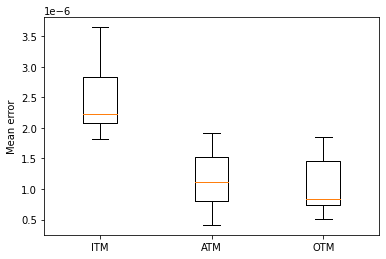

In [53]:
strike_price_labels = ["ITM", "ATM", "OTM"]
plt.plot()
plt.boxplot([delta_slice_itm, delta_slice_atm, delta_slice_otm], labels = strike_price_labels, showfliers = False);
plt.ylabel("Mean error")
plt.savefig("strike_price_delta_slice.pdf")

In [54]:
delta_atm = delta_analysis_df[delta_analysis_df["Offset"] == 0]["Mean"]
delta_itm = delta_analysis_df[delta_analysis_df["Offset"] == -10]["Mean"]
delta_otm = delta_analysis_df[delta_analysis_df["Offset"] == 10]["Mean"]

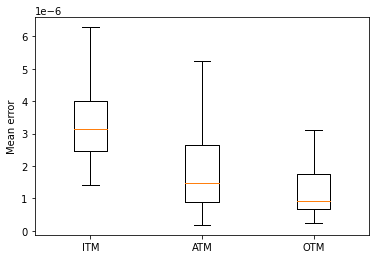

In [55]:
plt.plot()
plt.boxplot([delta_itm, delta_atm, delta_otm], labels = strike_price_labels, showfliers = False);
plt.ylabel("Mean error")
plt.savefig("strike_price_delta_general.pdf")

In [29]:
correct_dv_slice = dv_analysis_df[(dv_analysis_df["Frequency"] == 2) & (dv_analysis_df["TTM"] == 40)]
itm_dv_specific = correct_dv_slice[correct_dv_slice["Offset"] == -10]["Mean"]
atm_dv_specific = correct_dv_slice[correct_dv_slice["Offset"] == 0]["Mean"]
otm_dv_specific = correct_dv_slice[correct_dv_slice["Offset"] == 10]["Mean"]

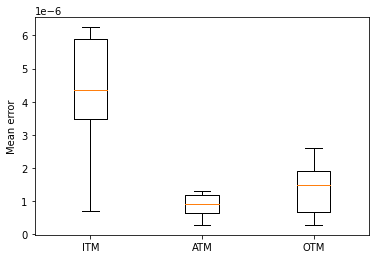

In [59]:
plt.plot()
plt.boxplot([itm_dv_specific, atm_dv_specific, otm_dv_specific], labels = strike_price_labels, showfliers = False);
plt.ylabel("Mean error");
plt.savefig("strike_price_delta_vega_specific.pdf")

In [31]:
itm_dv = dv_analysis_df[dv_analysis_df["Offset"] == -10]["Mean"]
atm_dv = dv_analysis_df[dv_analysis_df["Offset"] == 0]["Mean"]
otm_dv = dv_analysis_df[dv_analysis_df["Offset"] == 10]["Mean"]

In [32]:
atm_dv.mean()

1.805499916027033e-06

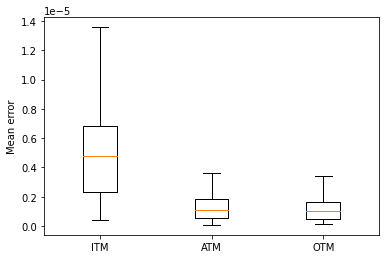

In [60]:
plt.plot()
plt.boxplot([itm_dv, atm_dv, otm_dv], labels = strike_price_labels[:], showfliers = False);
plt.ylabel("Mean error");
plt.savefig("strike_price_delta_vega_general.pdf")

## Frequency

In [34]:
# ATM call with different frequencies
offset = 0
ttm = 40
freq_means_specific = delta_analysis_df[(delta_analysis_df["Offset"] == offset) & (delta_analysis_df["TTM"] == ttm)].groupby("Frequency")
freq_means_specific = [data["Mean"].dropna() for i, data in freq_means_specific]
freq_means_dv_specific = dv_analysis_df[(dv_analysis_df["Offset"] == offset) & (dv_analysis_df["TTM"] == ttm)].groupby("Frequency")
freq_means_dv_specific = [data["Mean"].dropna() for i, data in freq_means_dv_specific]

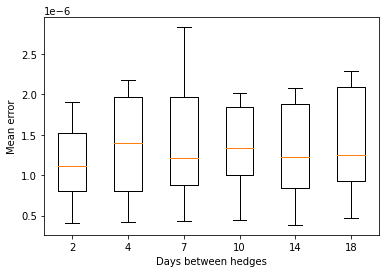

In [49]:
plt.plot()
plt.xlabel("Days between hedges")
plt.ylabel("Mean error")
plt.boxplot(freq_means_specific, showfliers = False, labels = freqs);
plt.savefig("freq_delta_1_spec.pdf")

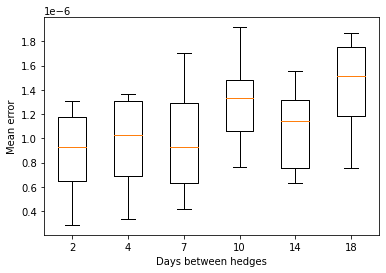

In [57]:
plt.plot()
plt.xlabel("Days between hedges")
plt.ylabel("Mean error")
plt.boxplot(freq_means_dv_specific, showfliers = False, labels = freqs);
plt.savefig("freq_delta_vega_specific.pdf")

In [36]:
freq_means = delta_analysis_df[(delta_analysis_df["Offset"] == offset)].groupby("Frequency")
freq_means = [data["Mean"].dropna() for i, data in freq_means]
freq_means_dv = dv_analysis_df[(dv_analysis_df["Offset"] == offset)].groupby("Frequency")
freq_means_dv = [data["Mean"].dropna() for i, data in freq_means_dv]

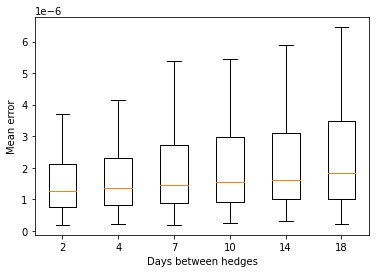

In [51]:
plt.plot()
plt.xlabel("Days between hedges")
plt.ylabel("Mean error")
plt.boxplot(freq_means, showfliers = False, labels = freqs);
plt.savefig("freq_delta_general.pdf")

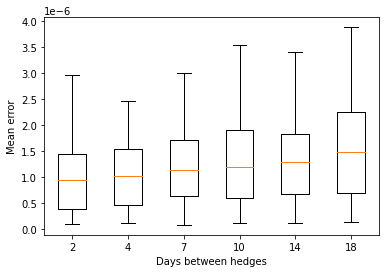

In [58]:
plt.plot()
plt.xlabel("Days between hedges")
plt.ylabel("Mean error")
plt.boxplot(freq_means_dv, showfliers = False, labels = freqs);
plt.savefig("freq_delta_vega_general.pdf")

## Combined analysis

In [128]:
def build_heatmap(correlation, labels1, labels2, title, xlabel, ylabel, size = (16, 8)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(correlation, cmap="seismic")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels1)))
    ax.set_yticks(np.arange(len(labels2)))
    
    ax.set_xticklabels(labels1, fontsize = 16)
    ax.set_yticklabels(labels2, fontsize = 16)
    
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)

    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels2)):
        for j in range(len(labels1)):
            text = ax.text(j, i, correlation[i, j],
                           ha="center", va="center", color="white", size=20)

    ax.set_title(title, fontsize = 16)
    fig.tight_layout()
    return (fig, ax)


In [42]:
combined_delta_df = delta_analysis_df.groupby(["Offset", "Frequency"], as_index = False).agg({"Mean": "mean"})
combined_dv_df = dv_analysis_df.groupby(["Offset", "Frequency"], as_index = False).agg({"Mean": "mean"})

In [43]:
combined_delta_df = combined_delta_df.sort_values(["Offset", "Frequency"])
combined_dv_df = combined_dv_df.sort_values(["Offset", "Frequency"])

In [44]:
mean_data = combined_delta_df["Mean"].to_numpy().reshape((len(offsets), len(freqs)))
mean_data = mean_data * 1e6
mean_data = np.round(mean_data, 2)

mean_dv_data = combined_dv_df["Mean"].to_numpy().reshape((len(offsets), len(freqs)))
mean_dv_data = mean_dv_data * 1e6
mean_dv_data = np.round(mean_dv_data, 2)

In [45]:
# Round and reverse the freq axis
freq_labels = list(reversed(freqs))

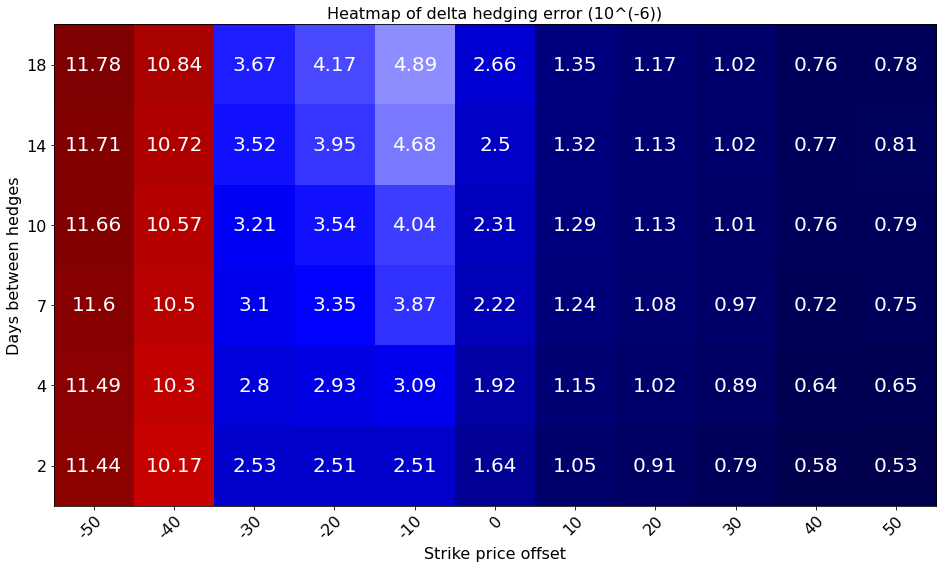

In [133]:
build_heatmap(np.flip(mean_data, axis = 1).T, offsets, freq_labels, "Heatmap of delta hedging error (10^(-6))", "Strike price offset", "Days between hedges");
plt.savefig("heatmap_delta_final.pdf")

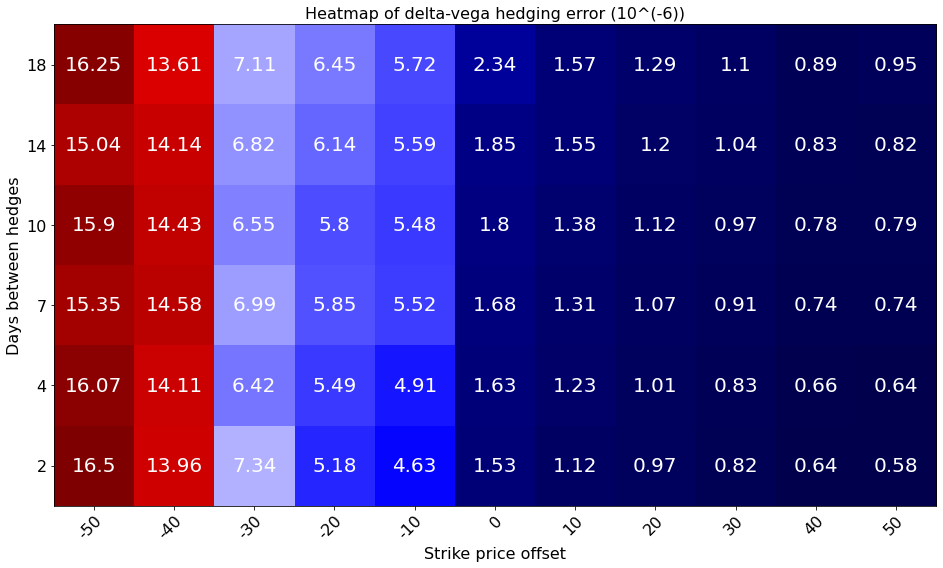

In [134]:
build_heatmap(np.flip(mean_dv_data, axis = 1).T, offsets, freq_labels, "Heatmap of delta-vega hedging error (10^(-6))", "Strike price offset", "Days between hedges");
plt.savefig("heatmap_dv_final.pdf")

## Comparison

In [84]:
atm_delta = delta_analysis_df[delta_analysis_df["Offset"] == 0]["Mean"]
atm_dv = dv_analysis_df[dv_analysis_df["Offset"] == 0]["Mean"]
strategy_labels = ["Delta", "Delta-Vega"]

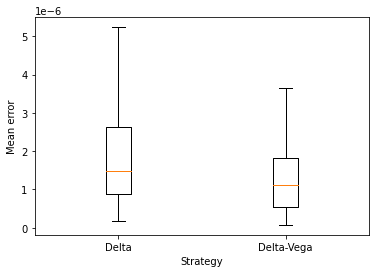

In [85]:
plt.xlabel("Strategy")
plt.ylabel("Mean error")
plt.boxplot([atm_delta, atm_dv], showfliers = False, labels = strategy_labels);
#plt.savefig("atm_comparison_1.pdf")

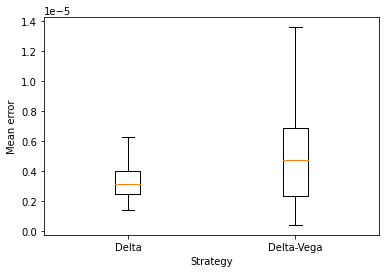

In [86]:
# comparing ITM -10
offset = -10
itm_delta = delta_analysis_df[delta_analysis_df["Offset"] == offset]["Mean"]
itm_dv = dv_analysis_df[dv_analysis_df["Offset"] == offset]["Mean"]

plt.xlabel("Strategy")
plt.ylabel("Mean error")
plt.boxplot([itm_delta, itm_dv], showfliers = False, labels = strategy_labels);
#plt.savefig("itm_comparison_1.pdf")

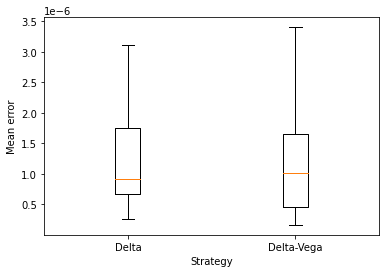

In [87]:
# comparing OTM 10
offset = 10
otm_delta = delta_analysis_df[delta_analysis_df["Offset"] == offset]["Mean"]
otm_dv = dv_analysis_df[dv_analysis_df["Offset"] == offset]["Mean"]

plt.xlabel("Strategy")
plt.ylabel("Mean error")
plt.boxplot([otm_delta, otm_dv], showfliers = False, labels = strategy_labels);
#plt.savefig("otm_comparison_1.pdf")

## Deviation analysis

In [103]:
offset = 0
ttm = 40
delta_t = 2

# Compare ATM 40 day options
delta_slice = delta_analysis_df[(delta_analysis_df["Offset"] == offset) & (delta_analysis_df["TTM"] == ttm) & (delta_analysis_df["Frequency"] == delta_t)]
dv_slice = dv_analysis_df[(dv_analysis_df["Offset"] == offset) & (dv_analysis_df["TTM"] == ttm) & (dv_analysis_df["Frequency"] == delta_t)]


strategy_labels = ["Delta", "Delta-Vega"]

In [104]:
delta_slice_std = delta_slice["Std"]
dv_slice_std = dv_slice["Std"]

In [105]:
delta_slice_std.mean()
dv_slice_std.mean()

1.6404441514845649e-06

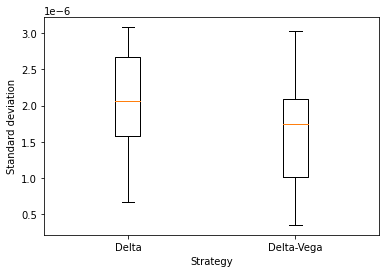

In [106]:
plt.plot()
plt.boxplot([delta_slice_std, dv_slice_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
# plt.savefig("std_compare_spec.pdf")
plt.plot();

In [107]:
# Overall ATM options
offset = 0
delta_gen = delta_analysis_df[(delta_analysis_df["Offset"] == offset)]
dv_gen = dv_analysis_df[(dv_analysis_df["Offset"] == offset)]

,ATM Strike,Offset,E,Frequency,TTM,Type,Mean,Std
,<float64>,<int64>,<float64>,<int64>,<int64>,<object>,<float64>,<float64>
2,0.46,0,0.46,2,36,ATM,1.068884e-05,0.000020
8,0.46,0,0.46,4,36,ATM,9.655528e-06,0.000019
14,0.46,0,0.46,7,36,ATM,1.113662e-05,0.000020
20,0.46,0,0.46,10,36,ATM,1.034098e-05,0.000022
...,...,...,...,...,...,...,...,...
26,0.46,0,0.46,14,36,ATM,1.433580e-05,0.000031
3549,0.54,0,0.54,18,36,ATM,6.521171e-07,0.000001
3554,0.54,0,0.54,18,38,ATM,9.650376e-07,0.000002
3559,0.54,0,0.54,18,40,ATM,1.080222e-06,0.000002


In [108]:
delta_gen_std = delta_gen["Std"]
dv_gen_std = dv_gen["Std"]

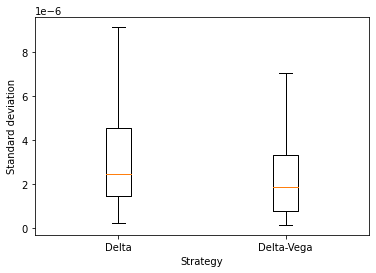

In [109]:
plt.plot()
plt.boxplot([delta_gen_std, dv_gen_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
# plt.savefig("std_compare_gen.pdf")
plt.plot();

In [119]:
offset = -10
ttm = 40
delta_t = 2

# Compare ATM 40 day options
delta_slice = delta_analysis_df[(delta_analysis_df["Offset"] == offset) & (delta_analysis_df["TTM"] == ttm) & (delta_analysis_df["Frequency"] == delta_t)]
dv_slice = dv_analysis_df[(dv_analysis_df["Offset"] == offset) & (dv_analysis_df["TTM"] == ttm) & (dv_analysis_df["Frequency"] == delta_t)]

delta_slice_std = delta_slice["Std"]
dv_slice_std = dv_slice["Std"]

# Overall
delta_gen = delta_analysis_df[(delta_analysis_df["Offset"] == offset)]
dv_gen = dv_analysis_df[(dv_analysis_df["Offset"] == offset)]

delta_gen_std = delta_gen["Std"]
dv_gen_std = dv_gen["Std"]

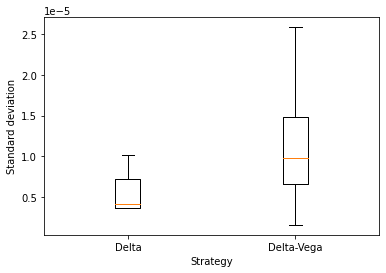

In [120]:
plt.plot()
plt.boxplot([delta_slice_std, dv_slice_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
plt.savefig("std_compare_spec_itm.pdf")
plt.plot();

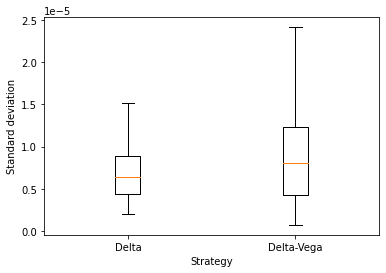

In [121]:
plt.plot()
plt.boxplot([delta_gen_std, dv_gen_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
plt.savefig("std_compare_gen_itm.pdf")
plt.plot();

In [122]:
offset = 10
ttm = 40
delta_t = 2

# Compare ATM 40 day options
delta_slice = delta_analysis_df[(delta_analysis_df["Offset"] == offset) & (delta_analysis_df["TTM"] == ttm) & (delta_analysis_df["Frequency"] == delta_t)]
dv_slice = dv_analysis_df[(dv_analysis_df["Offset"] == offset) & (dv_analysis_df["TTM"] == ttm) & (dv_analysis_df["Frequency"] == delta_t)]

delta_slice_std = delta_slice["Std"]
dv_slice_std = dv_slice["Std"]

# Overall
delta_gen = delta_analysis_df[(delta_analysis_df["Offset"] == offset)]
dv_gen = dv_analysis_df[(dv_analysis_df["Offset"] == offset)]

delta_gen_std = delta_gen["Std"]
dv_gen_std = dv_gen["Std"]

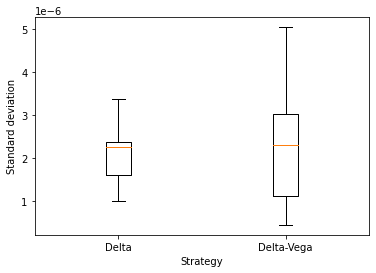

In [123]:
plt.plot()
plt.boxplot([delta_slice_std, dv_slice_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
plt.savefig("std_compare_spec_otm.pdf")
plt.plot();

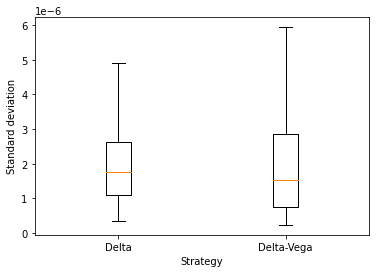

In [124]:
plt.plot()
plt.boxplot([delta_gen_std, dv_gen_std], labels = strategy_labels, showfliers = False);
plt.xlabel("Strategy")
plt.ylabel("Standard deviation")
plt.savefig("std_compare_gen_otm.pdf")
plt.plot();